<a href="https://colab.research.google.com/github/aesha15/plant-disease-classification/blob/main/Plant_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset


First, we download the `PlantVillage` dataset from Google Drive by using the unique `id` it holds and unzip the downloaded **PlantVillage.zip** into the **PlantVillage** dataset folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q /content/drive/MyDrive/DL/archive.zip

replace PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PlantVillage/Pepper__bell___Bacterial_spot/006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace PlantVillage/Pepper__bell___Bacterial_spot/006adb74-934f-448f-a14f-62181742127b___JR_B.Spot 3395.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# # Download a file based on its file ID.
# file_id = '1wz1k3XJlfq4L7YdKX4Ce2s9kv6kYHx9Gn'

# # Download dataset
# !gdown 'https://drive.google.com/drive/folders/1wz1k3XJlfq4L7YdKX4Ce2s9kv6kYHx9Gn/archive.zip'

# # Unzip the downloaded file
# !unzip -q archive.zip

# Import Libraries


Importing necessary libraries and modules required to build the classification model.

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Load Dataset

Initializing a few parameters required for the image dataset preprocessing.

In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 1000

# Path to the dataset folder
root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above.

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Here, we load the training data images by traversing through all the folders and converting all the images and labels into separate lists respectively.

*NOTE: We use a small portion of the entire dataset due to the computing limitations. Tweak `N_IMAGES` to include entire dataset.*

In [ ]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(root_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{root_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{root_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Image loading completed

Total number of images: 1500


Examine the labels/classes in the training dataset.

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  15


# Augment and Split Dataset

Using `ImageDataGenerator` to augment data by performing various operations on the training images.

In [ ]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True,
                             fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [ ]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Splitting data to train and test...


# Build Model


Defining the hyperparameters of the plant disease classification model.

In [ ]:
EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [ ]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

# Train Model


We initialize Adam optimizer with learning rate and decay parameters.

Also, we choose the type of loss and metrics for the model and compile it for training.

In [ ]:
# Initialize optimizer
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS,
                              verbose=1)

[INFO] Training network...
Epoch 1/25
37/37 [==============================] - 19s 492ms/step - loss: 0.0882 - accuracy: 0.7851 - val_loss: 1.0095 - val_accuracy: 0.2733
Epoch 2/25
37/37 [==============================] - 16s 435ms/step - loss: 0.0970 - accuracy: 0.7509 - val_loss: 0.7693 - val_accuracy: 0.2667
Epoch 3/25
37/37 [==============================] - 15s 415ms/step - loss: 0.0957 - accuracy: 0.7628 - val_loss: 0.6461 - val_accuracy: 0.3533
Epoch 4/25
37/37 [==============================] - 15s 415ms/step - loss: 0.0922 - accuracy: 0.7757 - val_loss: 2.0673 - val_accuracy: 0.4267
Epoch 5/25
37/37 [==============================] - 15s 415ms/step - loss: 0.0831 - accuracy: 0.8125 - val_loss: 1.3859 - val_accuracy: 0.2033
Epoch 6/25
37/37 [==============================] - 16s 416ms/step - loss: 0.0809 - accuracy: 0.8279 - val_loss: 0.5038 - val_accuracy: 0.4033
Epoch 7/25
37/37 [==============================] - 16s 420ms/step - loss: 0.0725 - accuracy: 0.8493 - val_loss: 0.

# Evaluate Model

Comparing the accuracy and loss by plotting the graph for training and validation.

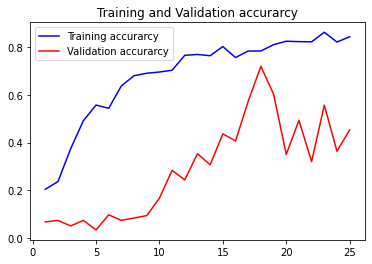

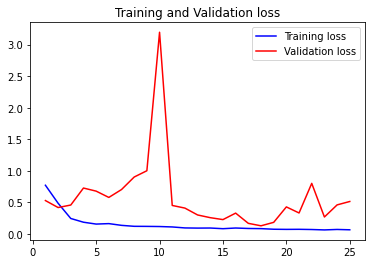

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
10/10 [==============================] - 0s 34ms/step - loss: 0.5154 - accuracy: 0.4533
Test Accuracy: 45.33333480358124


# Save Model

In [ ]:
# Dump pickle file of the model
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...


In [ ]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


# Test Model


We write the following `predict_disease` function to predict the class or disease of a plant image.

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    preds = model.predict(np_image)
    result=np.argmax(preds,axis=1)
    print((image_labels.classes_[result][0]))

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

1/1 [==============================] - 0s 19ms/step
Tomato_healthy


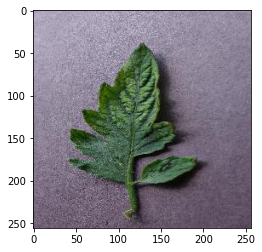

In [ ]:
predict_disease('/content/PlantVillage/Tomato__Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169.JPG')

1/1 [==============================] - 0s 36ms/step
Potato___Early_blight


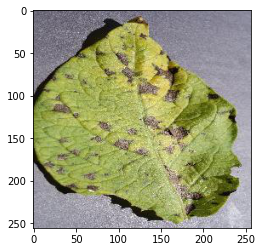

In [ ]:
predict_disease('/content/PlantVillage/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG')

In [ ]:
predict_disease('/content/PlantVillage/Tomato___Target_Spot/1006b3dd-22d8-41b8-b83d-08bf189fcdaa___Com.G_TgS_FL 8118.JPG')

Orange___Haunglongbing_(Citrus_greening)


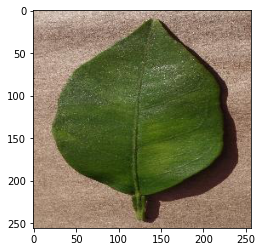

In [ ]:
predict_disease('/content/PlantVillage/val/Orange___Haunglongbing_(Citrus_greening)/02459e0c-a189-4dc9-a0dc-0548e36d0efb___CREC_HLB 5714.JPG')

# Reuse Model

We download the trained model and label transform saved in the Google Drive.

In [ ]:
# Download the trained model file based on its file ID.
file_id = '1E5jNzpM__7z67GRl1cbhHK71yKcPa8wl'
!gdown https://drive.google.com/uc?id={file_id}

# Download the labels file based on its file ID.
file_id = '1WsgEd3TG33Vj_9AAAT_WfJe_AqsuC9uu'
!gdown https://drive.google.com/uc?id={file_id}

Downloading...
From: https://drive.google.com/uc?id=1E5jNzpM__7z67GRl1cbhHK71yKcPa8wl
To: /content/plant_disease_classification_model.pkl
698MB [00:04, 162MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WsgEd3TG33Vj_9AAAT_WfJe_AqsuC9uu
To: /content/plant_disease_label_transform.pkl
100% 8.18k/8.18k [00:00<00:00, 8.17MB/s]


Importing necessary libraries and modules required to build the classification model.

In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Load the trained model and its labels for prediction.

In [ ]:
# Load model
filename = 'plant_disease_classification_model.pkl'
model = pickle.load(open(filename, 'rb'))

# Load labels
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

We use the `convert_image_to_array` function to resize an image and `predict_disease` function to predict the class or disease of a plant image.

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

Predict disease of any plant image.

Corn_(maize)___Northern_Leaf_Blight


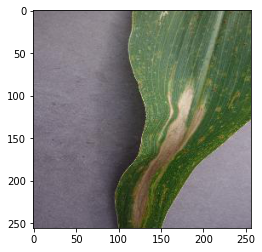

In [ ]:
predict_disease('/content/PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/028159fc-995e-455a-8d60-6d377580a898___RS_NLB 4023.JPG')